# 가장 성능이 좋았던 모델을 사용해 실제 데이터 예측

In [28]:
import pandas as pd #데이터 처리를 위한 pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler #모델 평가를 위한 scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
import time
import itertools
import os
import gc
import pickle
from xgboost import XGBRegressor #모델 구축을 위한 XGBoost
from xgboost import plot_importance
from matplotlib import rcParams #시각화를 위한 matplotlib

# 그림 크기 설정: matplotlib의 그림 크기를 설정합니다.
rcParams['figure.figsize'] = 12, 6

In [29]:
#데이터 불러오기
try:
    data = pd.read_csv('Data/test.csv', encoding='utf-8')
    train = pd.read_csv('Data/train.csv', encoding='utf-8')
except UnicodeDecodeError:
    #UTF-8로 실패한 경우 CP949로 재시도
    data = pd.read_csv('Data/test.csv', encoding='cp949')
    train = pd.read_csv('Data/train.csv', encoding='cp949')    

### Train Data Preprocessing

In [30]:
train['address'] = train['location'] + '/' + train['street']

In [31]:
train['type'].value_counts()
# 방의 타입에 따른 방개수 생성
# EXECUTIVE, MULTI-GENERATION는 결측치로 변경
tmp = []
for i in train['type']:
    if i == '5 ROOM':
        tmp.append(5)
    elif i == '4 ROOM':
        tmp.append(4)
    elif i == '3 ROOM':
        tmp.append(3)
    elif i == '2 ROOM':
        tmp.append(2)
    elif i == '1 ROOM':
        tmp.append(1)
    elif i == 'EXECUTIVE':
        tmp.append(None)
    else :
        tmp.append(None)
    
train['type_num'] = tmp

# 방개수 결측치 중앙값으로 -> execute 값을 none 값으로 했는데 그걸 median()메서드를 사용하여 전체 값의 중앙값으로 설정해줌
tmp = []

tmp = train['type_num'].fillna(train['type_num'].median())
train['type_num'] = tmp
train['type_num']

# 결측치 확인
train['type_num'].isna().sum()

0

In [32]:
# 방개수에 따른 방하나 평균 면적(m^2)
tmp = []
for num_rooms, area_sqm in zip(train['type_num'], train['area_sqm']):
    tmp.append(round(area_sqm/num_rooms, 3))
train['area_per_room'] = tmp

In [33]:
# 지역별 평균 집값으로 학습에 사용할 price를 생성

pivot_1 = pd.pivot_table(train, index='address', values='price', aggfunc=['count', 'mean', 'median'])
pivot_1.columns = ['count', 'mean', 'median']

In [34]:
tmp = []
for i in train['address']:
    for j in pivot_1.index:
        if i == j:
            tmp.append(pivot_1.loc[[i]]['mean'].values[0])

In [35]:
train['priceMean_inAddress'] = tmp

In [36]:
train

,house_id,date,location,type,block,street,storey_range,area_sqm,flat_model,commence_date,price,address,type_num,area_per_room,priceMean_inAddress
0,199577,2006-09,Raleigh,5 ROOM,107D,Agawan Court,07 TO 09,110.0,D,2003,313000.0,Raleigh/Agawan Court,5.0,22.000,388121.105812
1,217021,2007-06,Fresno,3 ROOM,678,Cleo St,07 TO 09,64.0,N,1988,167000.0,Fresno/Cleo St,3.0,21.333,247629.816410
2,308062,2010-09,Tucson,4 ROOM,5,E Pleasant View Way,10 TO 12,92.0,K,1976,430000.0,Tucson/E Pleasant View Way,4.0,23.000,250972.789366
3,212465,2007-04,Austin,4 ROOM,326,Park Hollow Ln,10 TO 12,92.0,K,1977,303800.0,Austin/Park Hollow Ln,4.0,23.000,236038.387786
4,60654,2001-10,Honolulu,4 ROOM,794,Ala Puawa Place,04 TO 06,102.0,G,1998,212000.0,Honolulu/Ala Puawa Place,4.0,25.500,312744.576923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271716,101563,2003-01,Omaha,4 ROOM,483,Sandra Ln,04 TO 06,103.0,G,1989,232000.0,Omaha/Sandra Ln,4.0,25.750,323124.984746
271717,28297,2000-11,Omaha,5 ROOM,615,Atkin Rd,10 TO 12,134.0,G,1996,428000.0,Omaha/Atkin Rd,5.0,26.800,437646.389041
271718,321995,2011-04,Boston,5 ROOM,390,Kempton Street,13 TO 15,118.0,D,2004,548888.0,Boston/Kempton Street,5.0,23.600,415951.990544
271719,308162,2010-09,Fresno,4 ROOM,968,Magnolia Dale Dr,13 TO 15,90.0,I,1999,360000.0,Fresno/Magnolia Dale Dr,4.0,22.500,326226.186196


In [37]:
# 'date' 컬럼을 datetime 타입으로 변환하고, 연, 월 로 분리
tmp = {}
tmp['date'] = pd.to_datetime(train['date'])
train['Year'] = tmp['date'].dt.year
train['Month'] = tmp['date'].dt.month
train.drop('date', axis = 1, inplace = True)

In [38]:
#팔리기까지의 기간
tmp_list = []

for i, j in zip(train['commence_date'], train['Year']):
    tmp_list.append(j-i)

train['time_to_sell'] = tmp_list

In [39]:
#  2000~2012년의 미국 금리 데이터를 가져옴
interest_rate_df = pd.read_csv('Data/interest_rate.csv')
interest_rate_df

,interest_rate_date,interest_rate
0,2012-12-13,0.25
1,2012-10-25,0.25
2,2012-09-14,0.25
3,2012-08-02,0.25
4,2012-06-21,0.25
...,...,...
73,2001-02-01,5.50
74,2001-01-04,6.00
75,2000-05-17,6.50
76,2000-03-22,6.00


In [40]:
# 날자 데이터를 비교하여 당일의 금리를 확인하여 저장

tmp = interest_rate_df['interest_rate'][77]
tmp_interest_rate = []

for year, month in zip(train['Year'], train['Month']):
    date = str(year) + '-' + str(month)
    # print(pd.Timestamp(date))
    
    for interest_date, interest_rate in zip(interest_rate_df['interest_rate_date'][::-1], interest_rate_df['interest_rate'][::-1]):
        if pd.Timestamp(date) < pd.Timestamp(interest_date):
            # 금리 갱신일 이 날자보다 커지면 그 이전 날의 금리(tmp)를 저장
            tmp_interest_rate.append(tmp)
            tmp = interest_rate_df['interest_rate'][77]
            break
        # 금리 갱신일이 당일 날자보다 낮다면 해당의 금리로 tmp를 갱신
        tmp = interest_rate

In [41]:
# 생성한 리스트를 dataframe에 합침
train['interest_rate'] = tmp_interest_rate

In [42]:
train

,house_id,location,type,block,street,storey_range,area_sqm,flat_model,commence_date,price,address,type_num,area_per_room,priceMean_inAddress,Year,Month,time_to_sell,interest_rate
0,199577,Raleigh,5 ROOM,107D,Agawan Court,07 TO 09,110.0,D,2003,313000.0,Raleigh/Agawan Court,5.0,22.000,388121.105812,2006,9,3,5.25
1,217021,Fresno,3 ROOM,678,Cleo St,07 TO 09,64.0,N,1988,167000.0,Fresno/Cleo St,3.0,21.333,247629.816410,2007,6,19,5.25
2,308062,Tucson,4 ROOM,5,E Pleasant View Way,10 TO 12,92.0,K,1976,430000.0,Tucson/E Pleasant View Way,4.0,23.000,250972.789366,2010,9,34,0.25
3,212465,Austin,4 ROOM,326,Park Hollow Ln,10 TO 12,92.0,K,1977,303800.0,Austin/Park Hollow Ln,4.0,23.000,236038.387786,2007,4,30,5.25
4,60654,Honolulu,4 ROOM,794,Ala Puawa Place,04 TO 06,102.0,G,1998,212000.0,Honolulu/Ala Puawa Place,4.0,25.500,312744.576923,2001,10,3,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271716,101563,Omaha,4 ROOM,483,Sandra Ln,04 TO 06,103.0,G,1989,232000.0,Omaha/Sandra Ln,4.0,25.750,323124.984746,2003,1,14,1.25
271717,28297,Omaha,5 ROOM,615,Atkin Rd,10 TO 12,134.0,G,1996,428000.0,Omaha/Atkin Rd,5.0,26.800,437646.389041,2000,11,4,6.50
271718,321995,Boston,5 ROOM,390,Kempton Street,13 TO 15,118.0,D,2004,548888.0,Boston/Kempton Street,5.0,23.600,415951.990544,2011,4,7,0.25
271719,308162,Fresno,4 ROOM,968,Magnolia Dale Dr,13 TO 15,90.0,I,1999,360000.0,Fresno/Magnolia Dale Dr,4.0,22.500,326226.186196,2010,9,11,0.25


C:\Users\CHOI Je Woo\AppData\Local\Temp\ipykernel_17164\1534458401.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(), annot=True)


<Axes: >

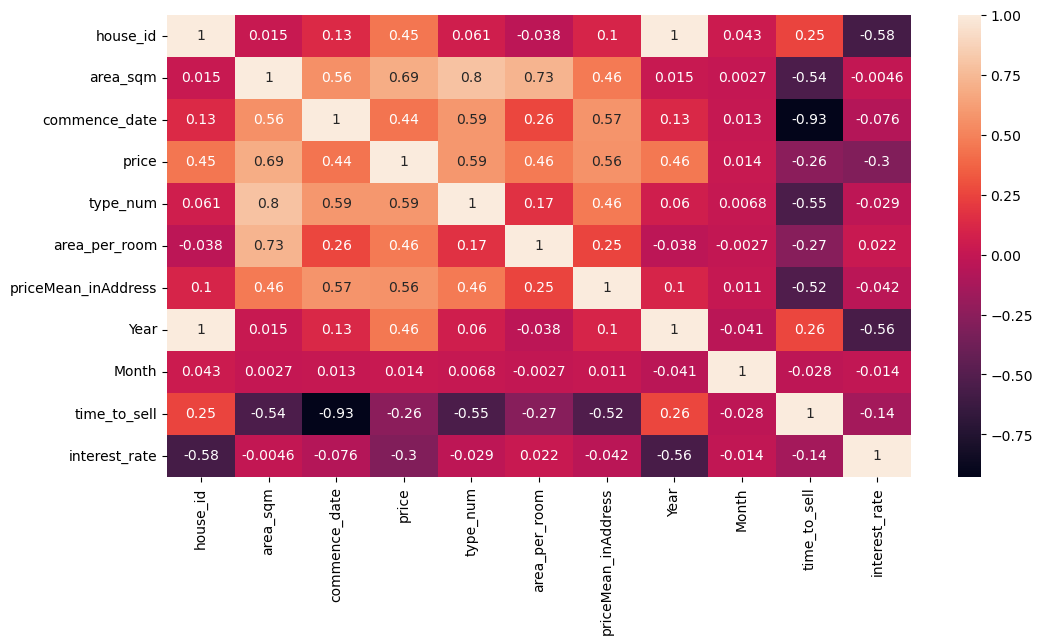

In [43]:
sns.heatmap(train.corr(), annot=True)

In [44]:
#라벨 인코딩: 모델이 이해하기 쉽도록 범주형 데이터를 숫자로 분류하여 줌

categorial_features = ['type', 'block', 'storey_range', 'flat_model', 'commence_date', 'address', 'Year', 'Month']
numerical_features = ['area_sqm', 'type_num', 'area_per_room', 'priceMean_inAddress', 'time_to_sell', 'interest_rate']

le = LabelEncoder()
for i in categorial_features:
    train[i] = le.fit_transform(train[i])

scaler = MinMaxScaler()
train[numerical_features] = scaler.fit_transform(train[numerical_features])

In [45]:
#라벨 인코딩 후 Object(문자열) 컬럼들을 제거 함.
#train = train.drop(['address', 'location', 'street', 'type'], axis = 1)
train = train.drop(['location', 'street'], axis = 1)

In [46]:
train

,house_id,type,block,storey_range,area_sqm,flat_model,commence_date,price,address,type_num,area_per_room,priceMean_inAddress,Year,Month,time_to_sell,interest_rate
0,199577,4,34,2,0.325397,3,37,313000.0,346,1.00,0.085474,0.495570,6,8,0.086957,0.80
1,217021,2,1445,2,0.142857,13,22,167000.0,131,0.50,0.076923,0.265648,7,5,0.434783,0.80
2,308062,3,1092,3,0.253968,10,10,430000.0,458,0.75,0.098295,0.271119,10,8,0.760870,0.00
3,212465,3,742,3,0.253968,10,11,303800.0,62,0.75,0.098295,0.246678,7,3,0.673913,0.80
4,60654,3,1662,1,0.293651,6,32,212000.0,153,0.75,0.130346,0.372212,1,9,0.086957,0.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271716,101563,3,1004,1,0.297619,6,23,232000.0,315,0.75,0.133551,0.389200,3,0,0.326087,0.16
271717,28297,4,1257,3,0.420635,6,30,428000.0,300,1.00,0.147013,0.576621,0,10,0.108696,1.00
271718,321995,4,853,4,0.357143,3,38,548888.0,78,1.00,0.105987,0.541117,11,3,0.173913,0.00
271719,308162,3,1936,4,0.246032,8,33,360000.0,136,0.75,0.091885,0.394276,10,8,0.260870,0.00


### 모델 학습
- n_estimators = 470

In [47]:
X = train.drop(['price', 'time_to_sell', 'interest_rate', 'Month'], axis = 1)
y = train['price']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [49]:
model = XGBRegressor(
    max_depth=10,
    n_estimators = 470,
    min_child_weight=0.5,
    colsample_bytree=0.8,
    subsample=0.8,
    eta=0.1,
    seed=77
)

In [50]:
model.fit(
        X_train,
        y_train
    )

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=0.5, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=470,
             n_jobs=None, num_parallel_tree=None, ...)

In [51]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# 평가 지표 계산
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f'Train MAE: {train_mae}, Train R^2: {train_r2}')
print(f'Test MAE: {test_mae}, Test R^2: {test_r2}')

Train MAE: 7782.342519858303, Train R^2: 0.991209043205489
Test MAE: 11193.635111113028, Test R^2: 0.9797606902962727


In [52]:
# 교차 검증 수행 (5-Fold 교차 검증), 성능 지표로 MAE를 사용하며, cross_val_score는 기본적으로 점수가 클수록 좋다고 가정하므로 MAE의 음수 값을 사용합니다. 이는 MAE 값을 최대화하는 대신 최소화하기 위함입니다.
cv_scores = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'neg_mean_absolute_error')

print(cv_scores)

# MAE의 음수 값을 반환하므로, 이를 양수로 변환하여 해석
mae_scores = -cv_scores

print("교차 검증 MAE 점수:", mae_scores)
print("평균 MAE:", mae_scores.mean())
print("표준 편차:", mae_scores.std())

[-11350.8083964  -11415.887703   -11385.49495572 -11278.15903378
 -11452.13428074]
교차 검증 MAE 점수: [11350.8083964  11415.887703   11385.49495572 11278.15903378
 11452.13428074]
평균 MAE: 11376.49687393061
표준 편차: 59.47074723344989


### 실제 데이터 전처리

In [54]:
data['address'] = data['location'] + '/' + data['street']

In [55]:
# 방의 타입에 따른 방개수 생성
# EXECUTIVE, MULTI-GENERATION는 결측치로 변경
tmp = []
for i in data['type']:
    if i == '5 ROOM':
        tmp.append(5)
    elif i == '4 ROOM':
        tmp.append(4)
    elif i == '3 ROOM':
        tmp.append(3)
    elif i == '2 ROOM':
        tmp.append(2)
    elif i == '1 ROOM':
        tmp.append(1)
    elif i == 'EXECUTIVE':
        tmp.append(None)
    else :
        tmp.append(None)
    
data['type_num'] = tmp

# 방개수 결측치 중앙값으로 -> execute 값을 none 값으로 했는데 그걸 median()메서드를 사용하여 전체 값의 중앙값으로 설정해줌
tmp = []

tmp = data['type_num'].fillna(data['type_num'].median())
data['type_num'] = tmp
data['type_num']

# 결측치 확인
data['type_num'].isna().sum()

0

In [56]:
# 방개수에 따른 방하나 평균 면적(m^2)
tmp = []
for num_rooms, area_sqm in zip(data['type_num'], data['area_sqm']):
    tmp.append(round(area_sqm/num_rooms, 3))
data['area_per_room'] = tmp

In [63]:
# 라벨링 전 주소데이터를 위해 train을 다시 호출

try:
    train = pd.read_csv('Data/train.csv', encoding='utf-8')
except UnicodeDecodeError:
    #UTF-8로 실패한 경우 CP949로 재시도
    train = pd.read_csv('Data/train.csv', encoding='cp949')

train['address'] = train['location'] + '/' + train['street']

In [64]:
# 지역별 평균 집값으로 학습에 사용할 price를 생성
# 해당 피쳐는 train에서 사용한 피쳐를 가져와 사용

pivot_1 = pd.pivot_table(train, index='address', values='price', aggfunc=['count', 'mean', 'median'])
pivot_1.columns = ['count', 'mean', 'median']

In [66]:
tmp = []
for i in data['address']:
    for j in pivot_1.index:
        if i == j:
            tmp.append(pivot_1.loc[[i]]['mean'].values[0])

In [67]:
data['priceMean_inAddress'] = tmp

In [68]:
# 지역별 평균 집값에 결측치 존재 확인
data['priceMean_inAddress'].isna().sum()

0

In [69]:
data

,house_id,date,location,type,block,street,storey_range,area_sqm,flat_model,commence_date,address,type_num,area_per_room,priceMean_inAddress
0,2,2000-01,Austin,3 ROOM,174,Governors Row,04 TO 06,61.0,D,1986,Austin/Governors Row,3.0,20.333,230909.686786
1,5,2000-01,Austin,3 ROOM,218,Stonleigh Pl,07 TO 09,67.0,K,1976,Austin/Stonleigh Pl,3.0,22.333,244596.758450
2,22,2000-01,Austin,3 ROOM,443,Palisades Point Cove,07 TO 09,67.0,K,1979,Austin/Palisades Point Cove,3.0,22.333,231550.033564
3,23,2000-01,Austin,3 ROOM,443,Palisades Point Cove,07 TO 09,67.0,K,1979,Austin/Palisades Point Cove,3.0,22.333,231550.033564
4,28,2000-01,Austin,3 ROOM,435,Palisades Point Cove,04 TO 06,67.0,K,1979,Austin/Palisades Point Cove,3.0,22.333,231550.033564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67925,339632,2012-02,Riverside,4 ROOM,610,Northpark Dr,04 TO 06,84.0,N,1986,Riverside/Northpark Dr,4.0,21.000,257532.562073
67926,339639,2012-02,Riverside,5 ROOM,796,Laredo Rd,04 TO 06,123.0,D,1987,Riverside/Laredo Rd,5.0,24.600,228528.345345
67927,339642,2012-02,Riverside,5 ROOM,855,Laredo Rd,04 TO 06,127.0,D,1988,Riverside/Laredo Rd,5.0,25.400,228528.345345
67928,339643,2012-02,Riverside,5 ROOM,366,Laredo Rd,07 TO 09,122.0,D,1988,Riverside/Laredo Rd,5.0,24.400,228528.345345


In [70]:
# 'date' 컬럼을 datetime 타입으로 변환하고, 연, 월 로 분리
tmp = {}
tmp['date'] = pd.to_datetime(data['date'])
data['Year'] = tmp['date'].dt.year
data['Month'] = tmp['date'].dt.month
data.drop('date', axis = 1, inplace = True)

In [71]:
#팔리기까지의 기간
tmp_list = []

for i, j in zip(data['commence_date'], data['Year']):
    tmp_list.append(j-i)

data['time_to_sell'] = tmp_list

In [72]:
#  2000~2012년의 미국 금리 데이터를 가져옴
interest_rate_df = pd.read_csv('Data/interest_rate.csv')
interest_rate_df

,interest_rate_date,interest_rate
0,2012-12-13,0.25
1,2012-10-25,0.25
2,2012-09-14,0.25
3,2012-08-02,0.25
4,2012-06-21,0.25
...,...,...
73,2001-02-01,5.50
74,2001-01-04,6.00
75,2000-05-17,6.50
76,2000-03-22,6.00


In [73]:
# 날자 데이터를 비교하여 당일의 금리를 확인하여 저장

tmp = interest_rate_df['interest_rate'][77]
tmp_interest_rate = []

for year, month in zip(data['Year'], data['Month']):
    date = str(year) + '-' + str(month)
    # print(pd.Timestamp(date))
    
    for interest_date, interest_rate in zip(interest_rate_df['interest_rate_date'][::-1], interest_rate_df['interest_rate'][::-1]):
        if pd.Timestamp(date) < pd.Timestamp(interest_date):
            # 금리 갱신일 이 날자보다 커지면 그 이전 날의 금리(tmp)를 저장
            tmp_interest_rate.append(tmp)
            tmp = interest_rate_df['interest_rate'][77]
            break
        # 금리 갱신일이 당일 날자보다 낮다면 해당의 금리로 tmp를 갱신
        tmp = interest_rate

In [74]:
# 생성한 리스트를 dataframe에 합침
data['interest_rate'] = tmp_interest_rate

In [75]:
data

,house_id,location,type,block,street,storey_range,area_sqm,flat_model,commence_date,address,type_num,area_per_room,priceMean_inAddress,Year,Month,time_to_sell,interest_rate
0,2,Austin,3 ROOM,174,Governors Row,04 TO 06,61.0,D,1986,Austin/Governors Row,3.0,20.333,230909.686786,2000,1,14,5.75
1,5,Austin,3 ROOM,218,Stonleigh Pl,07 TO 09,67.0,K,1976,Austin/Stonleigh Pl,3.0,22.333,244596.758450,2000,1,24,5.75
2,22,Austin,3 ROOM,443,Palisades Point Cove,07 TO 09,67.0,K,1979,Austin/Palisades Point Cove,3.0,22.333,231550.033564,2000,1,21,5.75
3,23,Austin,3 ROOM,443,Palisades Point Cove,07 TO 09,67.0,K,1979,Austin/Palisades Point Cove,3.0,22.333,231550.033564,2000,1,21,5.75
4,28,Austin,3 ROOM,435,Palisades Point Cove,04 TO 06,67.0,K,1979,Austin/Palisades Point Cove,3.0,22.333,231550.033564,2000,1,21,5.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67925,339632,Riverside,4 ROOM,610,Northpark Dr,04 TO 06,84.0,N,1986,Riverside/Northpark Dr,4.0,21.000,257532.562073,2012,2,26,0.25
67926,339639,Riverside,5 ROOM,796,Laredo Rd,04 TO 06,123.0,D,1987,Riverside/Laredo Rd,5.0,24.600,228528.345345,2012,2,25,0.25
67927,339642,Riverside,5 ROOM,855,Laredo Rd,04 TO 06,127.0,D,1988,Riverside/Laredo Rd,5.0,25.400,228528.345345,2012,2,24,0.25
67928,339643,Riverside,5 ROOM,366,Laredo Rd,07 TO 09,122.0,D,1988,Riverside/Laredo Rd,5.0,24.400,228528.345345,2012,2,24,0.25


In [76]:
#라벨 인코딩: 모델이 이해하기 쉽도록 범주형 데이터를 숫자로 분류하여 줌

categorial_features = ['type', 'block', 'storey_range', 'flat_model', 'commence_date', 'address', 'Year', 'Month']
numerical_features = ['area_sqm', 'type_num', 'area_per_room', 'priceMean_inAddress', 'time_to_sell', 'interest_rate']

le = LabelEncoder()
for i in categorial_features:
    data[i] = le.fit_transform(data[i])

scaler = MinMaxScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

In [77]:
#라벨 인코딩 후 Object(문자열) 컬럼들을 제거 함.
#train = train.drop(['address', 'location', 'street', 'type'], axis = 1)
data = data.drop(['location', 'street'], axis = 1)

In [80]:
data

,house_id,type,block,storey_range,area_sqm,flat_model,commence_date,address,type_num,area_per_room,priceMean_inAddress,Year,Month,time_to_sell,interest_rate
0,2,2,210,1,0.135021,3,20,51,0.50,0.055299,0.238285,0,0,0.340426,0.88
1,5,2,352,2,0.160338,10,10,62,0.50,0.082949,0.260684,0,0,0.553191,0.88
2,22,2,922,2,0.160338,10,13,60,0.50,0.082949,0.239333,0,0,0.489362,0.88
3,23,2,922,2,0.160338,10,13,60,0.50,0.082949,0.239333,0,0,0.489362,0.88
4,28,2,912,1,0.160338,10,13,60,0.50,0.082949,0.239333,0,0,0.489362,0.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67925,339632,3,1230,1,0.232068,13,20,364,0.75,0.064520,0.281855,12,1,0.595745,0.00
67926,339639,4,1633,1,0.396624,3,21,359,1.00,0.114289,0.234388,12,1,0.574468,0.00
67927,339642,4,1719,1,0.413502,3,22,359,1.00,0.125349,0.234388,12,1,0.553191,0.00
67928,339643,4,807,2,0.392405,3,22,359,1.00,0.111524,0.234388,12,1,0.553191,0.00


### 실제 데이터 예측

In [82]:
X_real_data = data.drop(['time_to_sell', 'interest_rate', 'Month'], axis = 1)

In [83]:
y_pred_real_data = model.predict(X_real_data)

In [85]:
result_df = pd.DataFrame({
    'house_id' : data['house_id'],
    'price' : y_pred_real_data
})

In [86]:
result_df

,house_id,price
0,2,146129.109375
1,5,163045.156250
2,22,165883.281250
3,23,165883.281250
4,28,163027.500000
...,...,...
67925,339632,393208.562500
67926,339639,500628.625000
67927,339642,512502.156250
67928,339643,459590.718750


In [87]:
result_df.to_csv('./data/submission.csv', index=False)

In [88]:
a = pd.read_csv('./data/submission.csv')
a

,house_id,price
0,2,146129.11
1,5,163045.16
2,22,165883.28
3,23,165883.28
4,28,163027.50
...,...,...
67925,339632,393208.56
67926,339639,500628.62
67927,339642,512502.16
67928,339643,459590.72
